In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TS_FineTune


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3432416747.py", line 1, in <cell line: 0>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/TS_FineTune')
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
                              ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
             ^^^^^^^^^^^
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occ

RUN_STAMP: c9d3c1381511c34b {'SEED': 1337, 'deterministic': True, 'torch': '2.8.0+cu126', 'cuda': '12.6', 'device': 'cuda', 'plant': 'tanks'}
[GPU] Enabling torch-based fast-path.
Generating offline dataset for TANKS...
Pretraining g_pre...

--- MC Run 1/100 for Scenario: OOD 1 ---

--- MC Run 2/100 for Scenario: OOD 1 ---

--- MC Run 3/100 for Scenario: OOD 1 ---

--- MC Run 4/100 for Scenario: OOD 1 ---

--- MC Run 5/100 for Scenario: OOD 1 ---

--- MC Run 6/100 for Scenario: OOD 1 ---

--- MC Run 7/100 for Scenario: OOD 1 ---

--- MC Run 8/100 for Scenario: OOD 1 ---

--- MC Run 9/100 for Scenario: OOD 1 ---

--- MC Run 10/100 for Scenario: OOD 1 ---

--- MC Run 11/100 for Scenario: OOD 1 ---

--- MC Run 12/100 for Scenario: OOD 1 ---

--- MC Run 13/100 for Scenario: OOD 1 ---

--- MC Run 14/100 for Scenario: OOD 1 ---

--- MC Run 15/100 for Scenario: OOD 1 ---

--- MC Run 16/100 for Scenario: OOD 1 ---

--- MC Run 17/100 for Scenario: OOD 1 ---

--- MC Run 18/100 for Scenario: OOD 

/tmp/ipython-input-121029504.py:591: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(mse_data, labels=method_names, vert=True, patch_artist=True, showfliers=True)


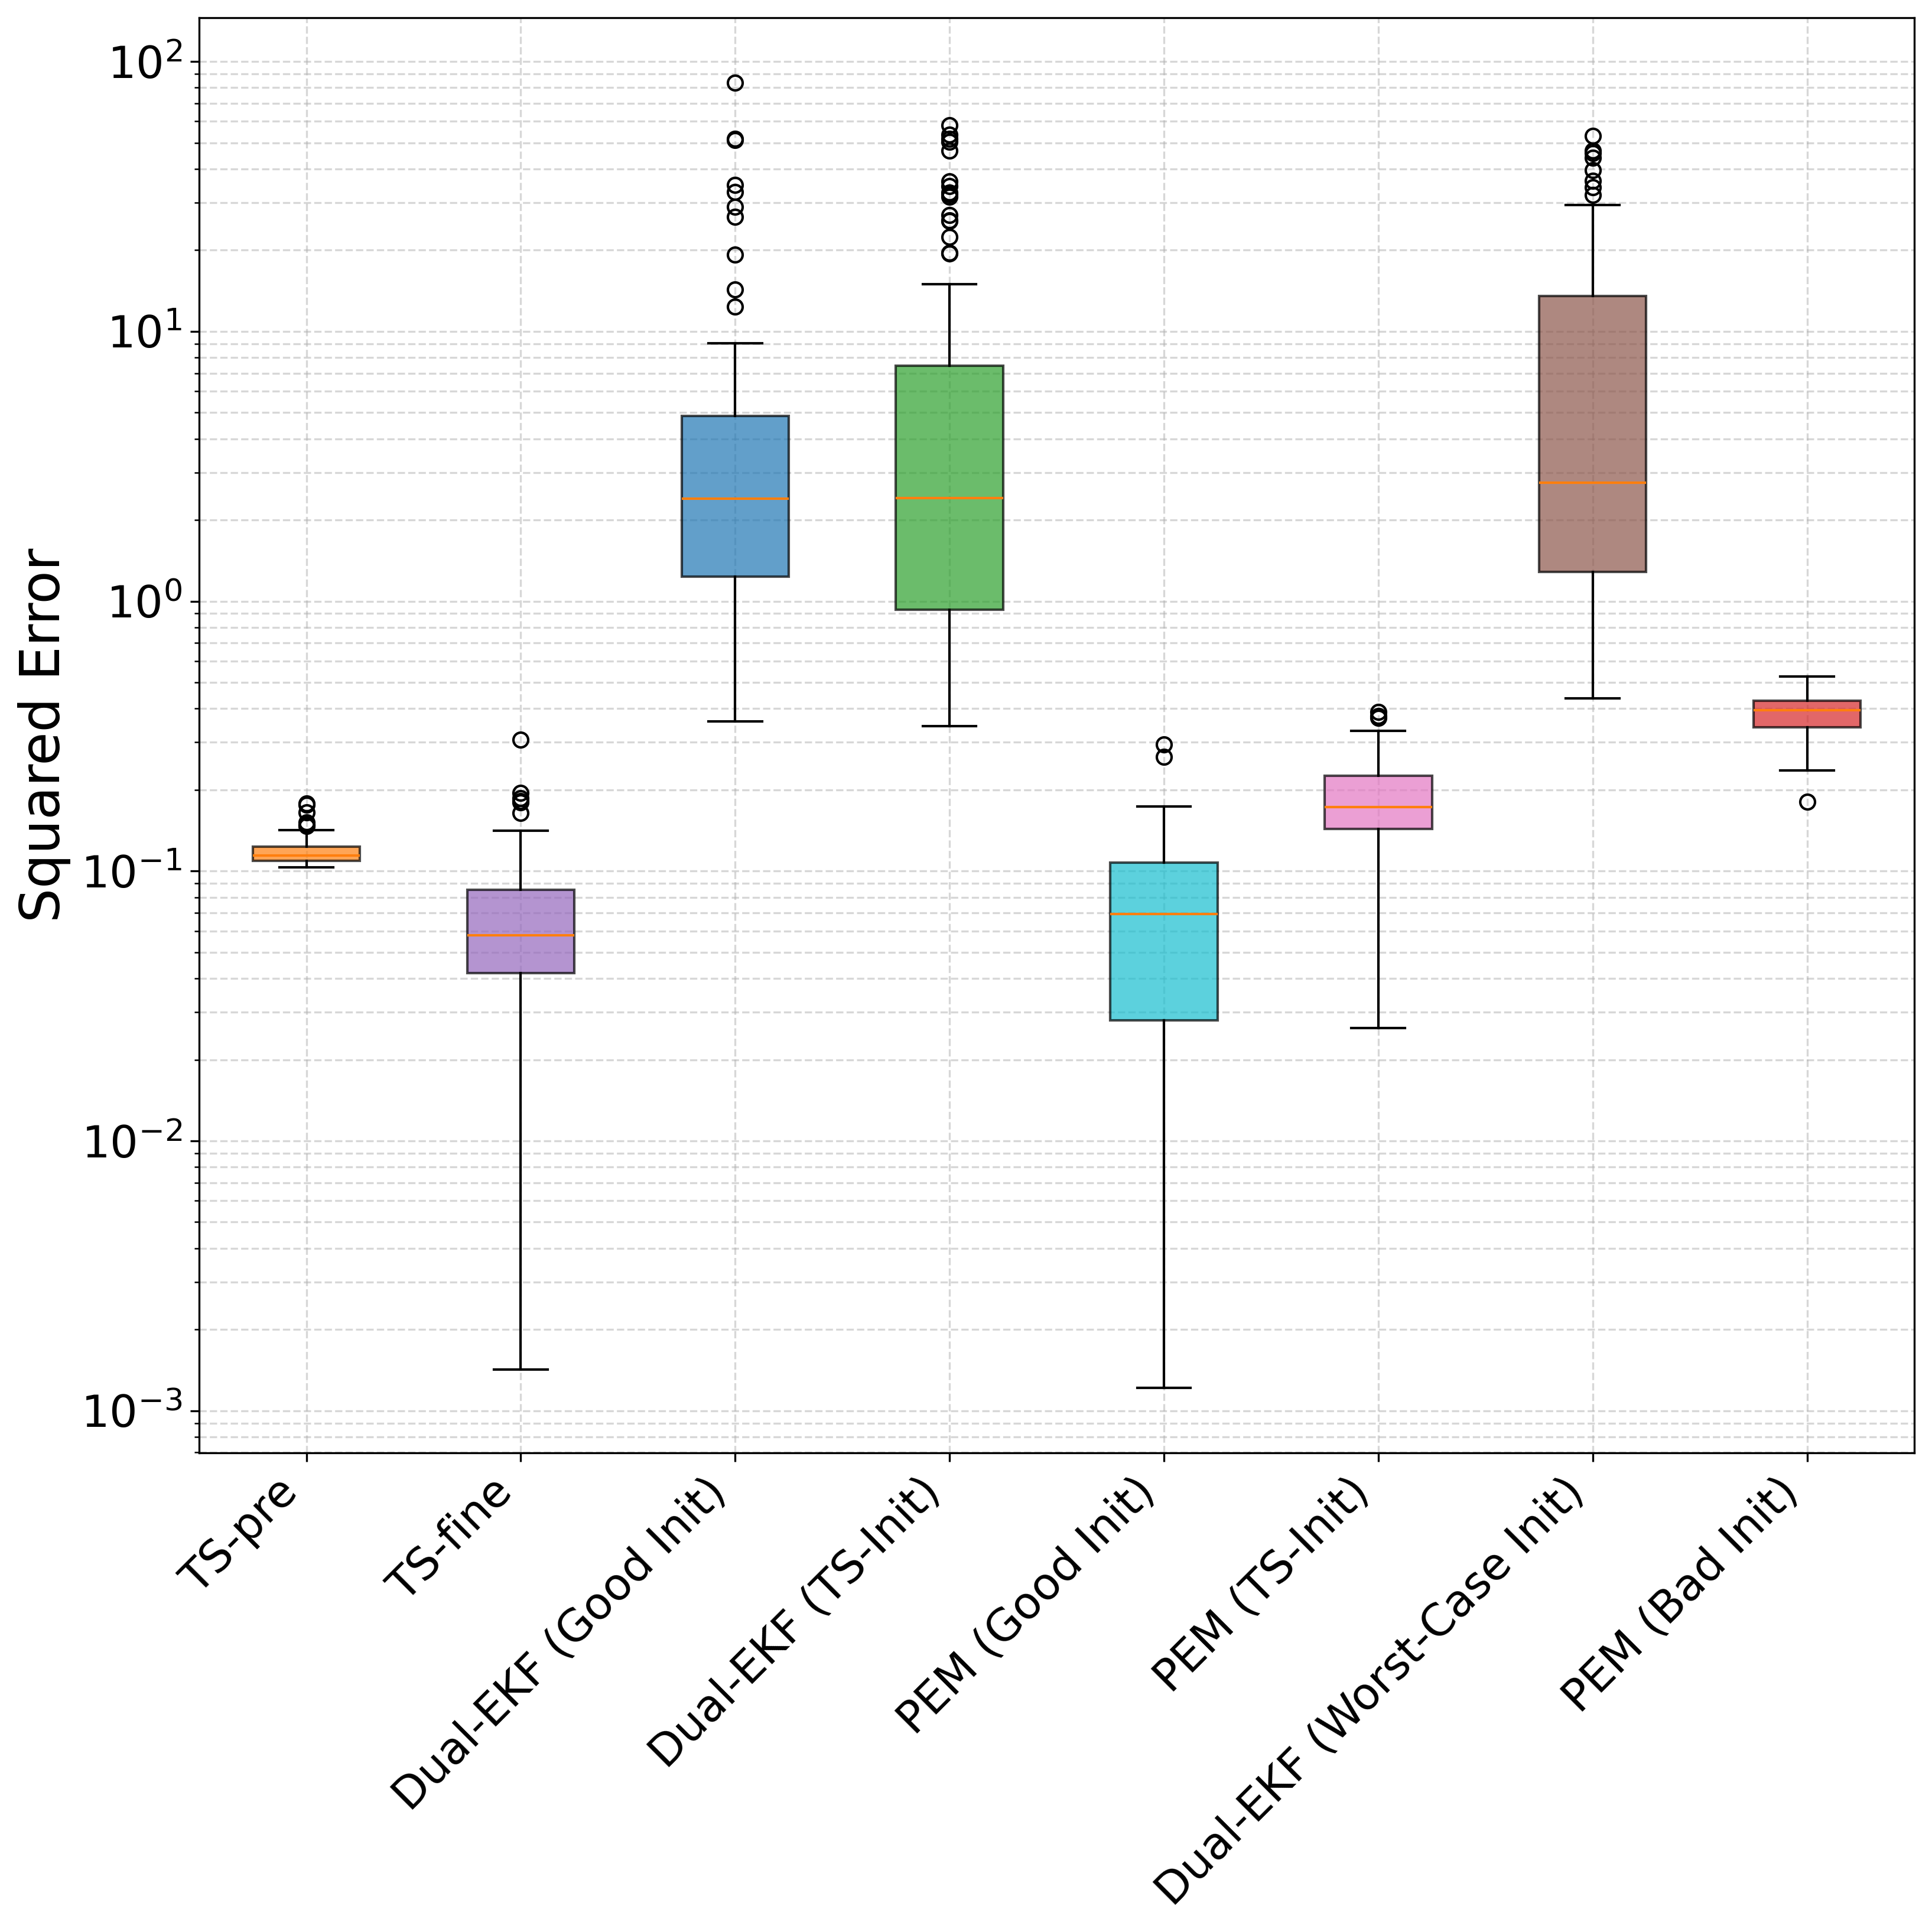


--- MC Run 1/100 for Scenario: OOD 2 ---

--- MC Run 2/100 for Scenario: OOD 2 ---

--- MC Run 3/100 for Scenario: OOD 2 ---

--- MC Run 4/100 for Scenario: OOD 2 ---

--- MC Run 5/100 for Scenario: OOD 2 ---

--- MC Run 6/100 for Scenario: OOD 2 ---

--- MC Run 7/100 for Scenario: OOD 2 ---

--- MC Run 8/100 for Scenario: OOD 2 ---

--- MC Run 9/100 for Scenario: OOD 2 ---

--- MC Run 10/100 for Scenario: OOD 2 ---

--- MC Run 11/100 for Scenario: OOD 2 ---

--- MC Run 12/100 for Scenario: OOD 2 ---

--- MC Run 13/100 for Scenario: OOD 2 ---

--- MC Run 14/100 for Scenario: OOD 2 ---

--- MC Run 15/100 for Scenario: OOD 2 ---

--- MC Run 16/100 for Scenario: OOD 2 ---

--- MC Run 17/100 for Scenario: OOD 2 ---

--- MC Run 18/100 for Scenario: OOD 2 ---

--- MC Run 19/100 for Scenario: OOD 2 ---

--- MC Run 20/100 for Scenario: OOD 2 ---

--- MC Run 21/100 for Scenario: OOD 2 ---

--- MC Run 22/100 for Scenario: OOD 2 ---

--- MC Run 23/100 for Scenario: OOD 2 ---

--- MC Run 24/100 f

/tmp/ipython-input-121029504.py:591: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(mse_data, labels=method_names, vert=True, patch_artist=True, showfliers=True)


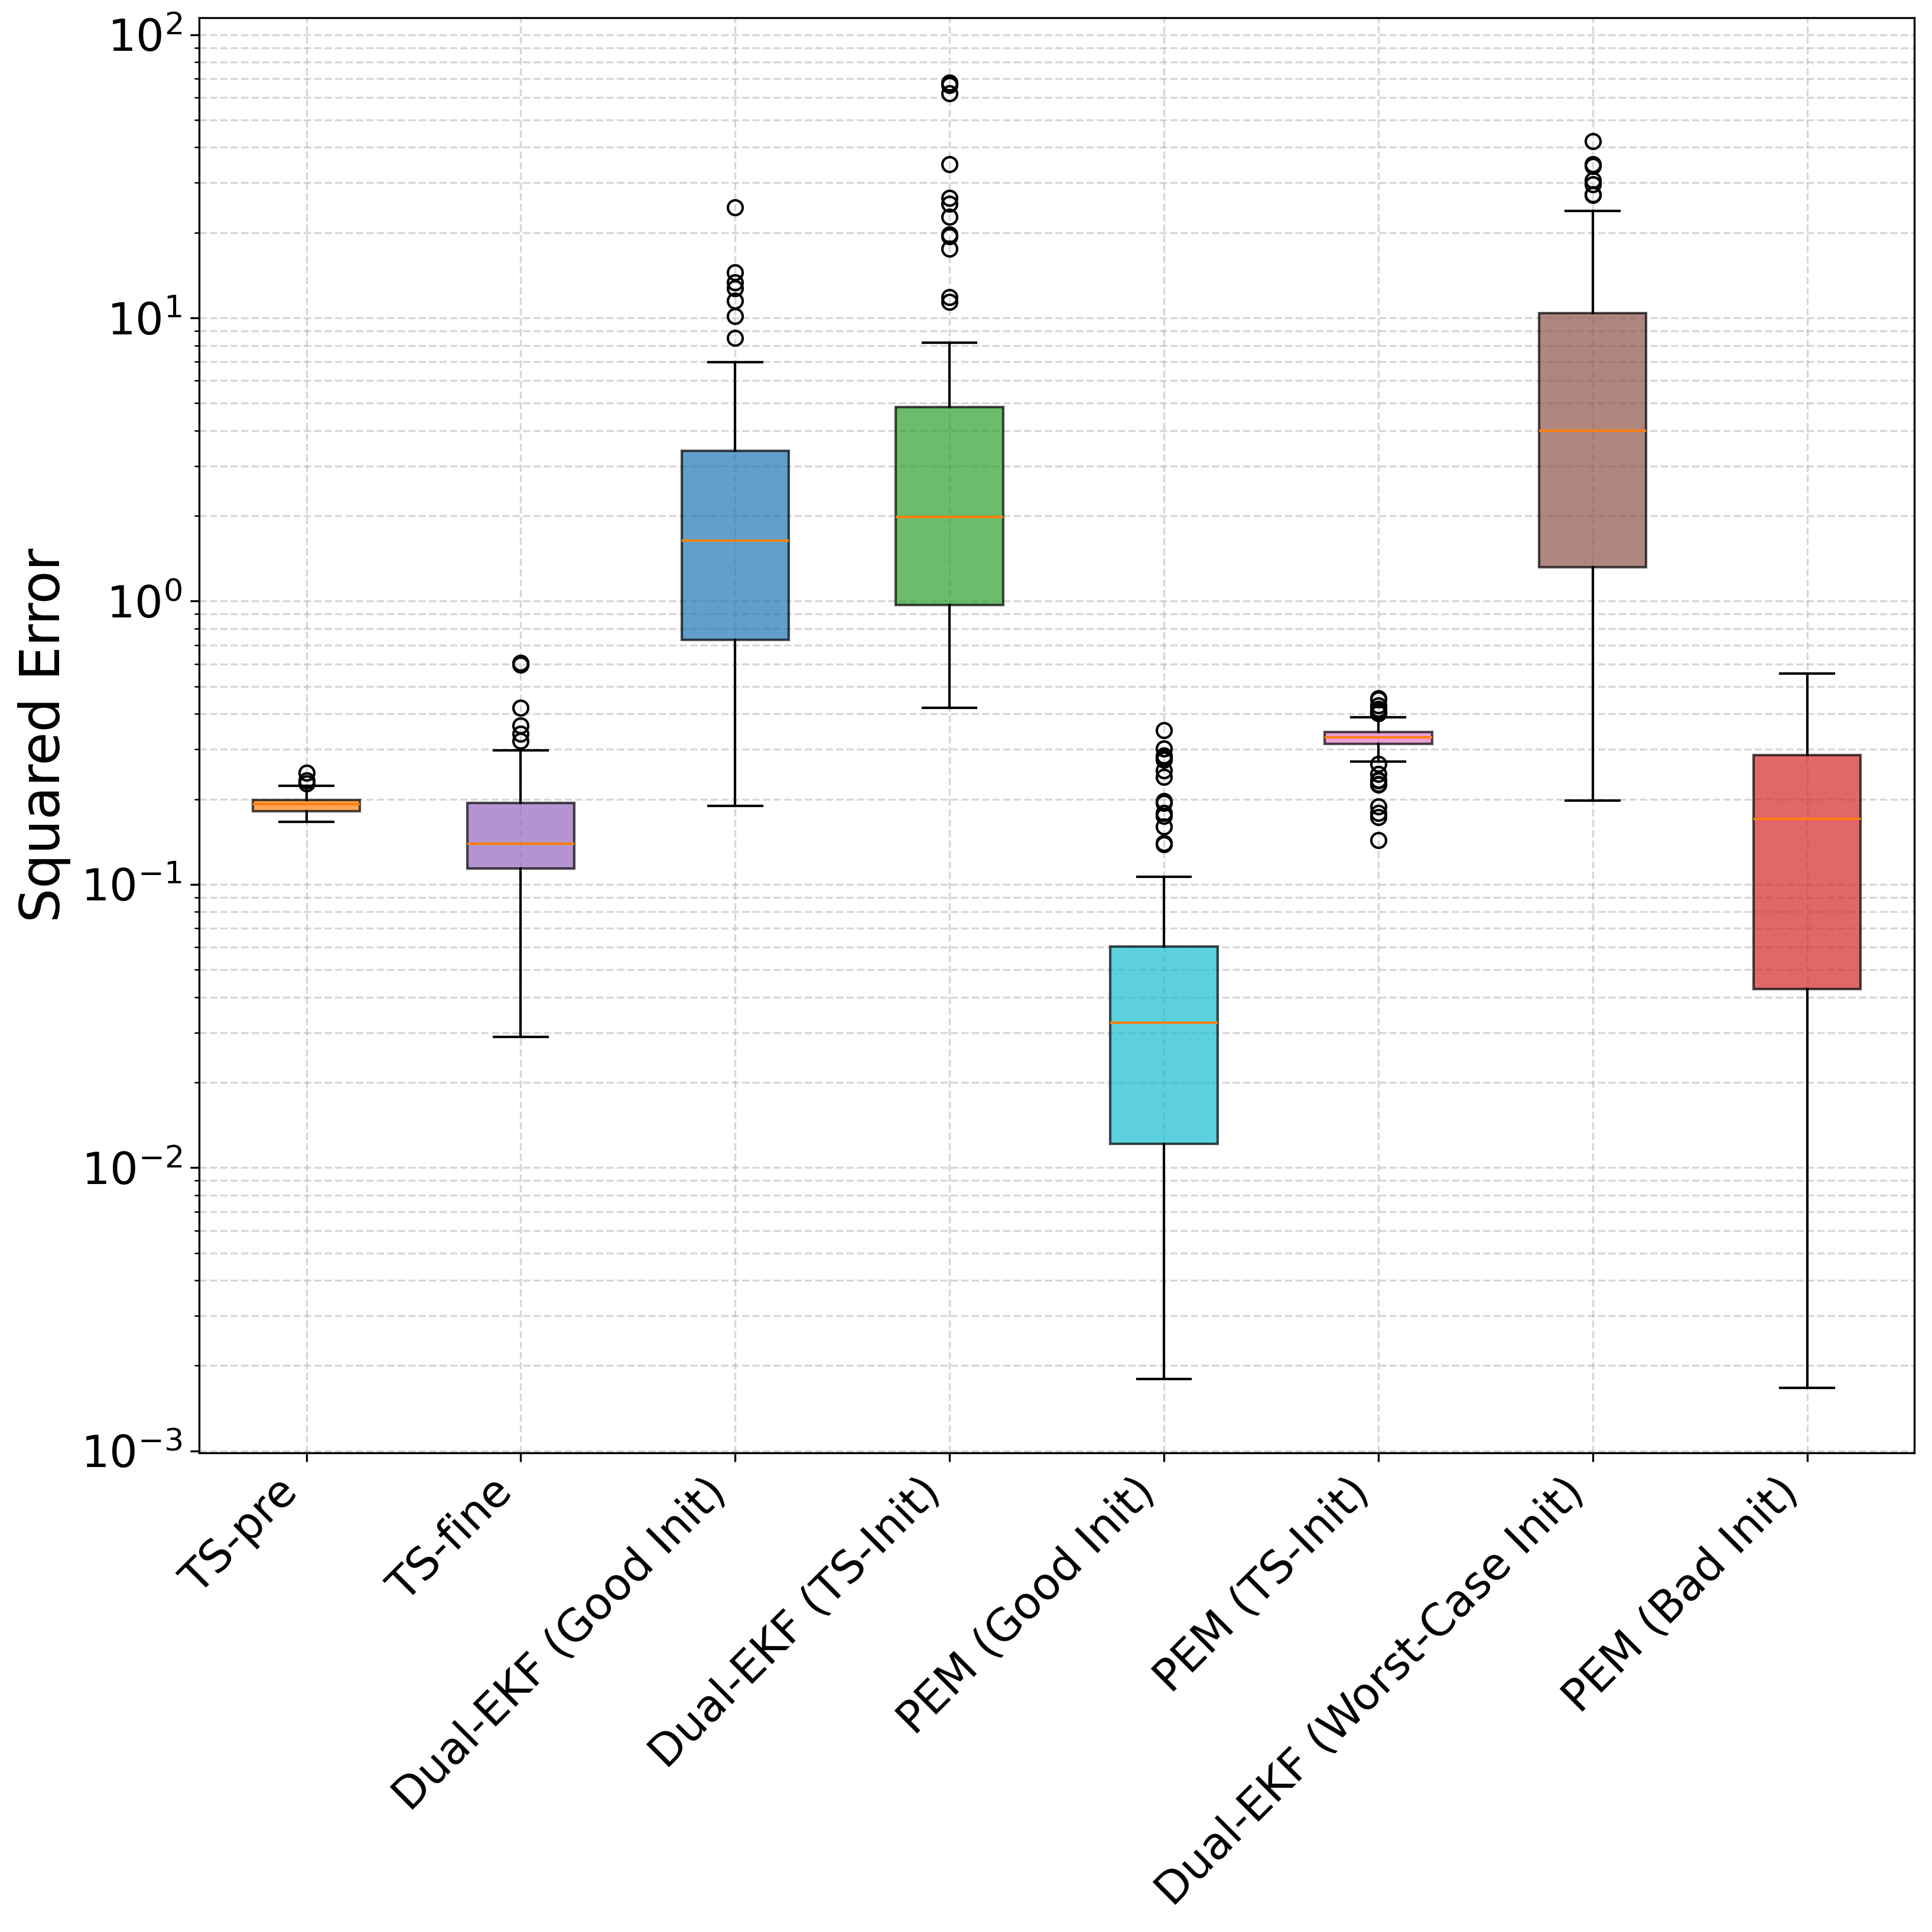

In [ ]:
#!/usr/bin/env python3
# =============================================================================
# Two-Stage Fine-Tuning (TS-fine) — Tanks
# =============================================================================
import os, random, hashlib, json, copy, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "pdf.fonttype": 42, "ps.fonttype": 42, "text.usetex": False,
    "svg.fonttype": "none", "font.family": "DejaVu Sans", "axes.unicode_minus": True
})

from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# =============================================================================
# 0) Reproducibility & device
# =============================================================================
SEED = 1337
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":16:8")
os.environ.setdefault("PYTHONHASHSEED", str(SEED))
DETERMINISTIC_TORCH = True

def seed_everything(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    if DETERMINISTIC_TORCH:
        torch.use_deterministic_algorithms(True, warn_only=False)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False

seed_everything(SEED)
torch.set_num_threads(1)

def _get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

DEVICE = _get_device()
try: torch.set_float32_matmul_precision("high")
except Exception: pass

def print_run_stamp(plant):
    payload = {
        "SEED": SEED, "deterministic": True, "torch": torch.__version__,
        "cuda": getattr(torch.version, "cuda", "cpu"), "device": DEVICE, "plant": plant,
    }
    print("RUN_STAMP:", hashlib.sha256(json.dumps(payload, sort_keys=True).encode()).hexdigest()[:16], payload)

# =============================================================================
# 1) Experiment configuration
# =============================================================================
PLANT = "tanks"; print_run_stamp(PLANT)
rng = np.random.default_rng(42)
N_MC_RUNS = 100

# --- Tanks plant-specific ---
DT=0.5; OFF_M=10000; M_FT=1000; N_SAMPLES=400; H_MAX=10.0; THETA_DIM=4
theta_dim = THETA_DIM
theta_off_lo=np.array([0.4,0.4,0.4,0.8]); theta_off_hi=np.array([0.8,0.8,0.8,1.2])
theta_glob_lo=np.array([0.1,0.1,0.1,0.5]); theta_glob_hi=np.array([1.5,1.5,1.5,1.5])
PARAM_NAMES=[f"k{i+1}" for i in range(THETA_DIM)]
TANKS_U_MIN, TANKS_U_MAX, TANKS_CLOCK_SAMPLES = 0.0, 3.0, 30
OOD_SCENARIOS = {
    "OOD 1": np.array([1.2, 1.2, 0.9, 1.0]),
    "OOD 2": np.array([1.3, 1.3, 0.6, 0.7]),
}

# Gate / noise & knobs
K_NOISE = 150
ALPHA   = 0.10
OFFLINE_RANDOM_U = True
HUBER_DELTA      = 0.6
GN_PRIOR_GAMMA   = 1e-4
GN_MULTI_STARTS  = 8
CLOUD_AXIS_MIX   = 0.55
na, nb = 64, 64

RESULTS_DIR = "results_tanks"; os.makedirs(RESULTS_DIR, exist_ok=True)

# =============================================================================
# 2) Features + MLP head
# =============================================================================
class MultiHeadMLP(nn.Module):
    def __init__(self, i_dim, o_dim, trunk_hidden=(256,256), head_hidden=64, head_depth=3, dropout=0.15):
        super().__init__()
        layers=[]; in_d=i_dim
        for h in trunk_hidden:
            layers += [nn.Linear(in_d, h), nn.LayerNorm(h), nn.LeakyReLU(), nn.Dropout(dropout)]
            in_d = h
        self.trunk = nn.Sequential(*layers)
        heads=[]
        for _ in range(o_dim):
            h_layers=[]; h_in=in_d
            for _ in range(head_depth):
                h_layers += [nn.Linear(h_in, head_hidden), nn.LayerNorm(head_hidden), nn.Tanh(), nn.Dropout(dropout)]
                h_in = head_hidden
            h_layers += [nn.Linear(h_in, 1)]
            heads.append(nn.Sequential(*h_layers))
        self.heads = nn.ModuleList(heads)

    def forward(self, x):
        z = self.trunk(x)
        return torch.cat([head(z) for head in self.heads], dim=1)

class MLPPerParamRegressor:
    def __init__(self, i_dim, o_dim, epochs=120, lr=1e-3, batch_size=64,
                 trunk_hidden=(256,256), head_hidden=64, head_depth=3, dropout=0.15,
                 ortho_lambda=5e-4, device=None):
        self.model = MultiHeadMLP(i_dim, o_dim, trunk_hidden, head_hidden, head_depth, dropout)
        self.scaler = StandardScaler()
        self.epochs=epochs; self.lr=lr; self.batch_size=batch_size
        self._device=torch.device(device if device is not None else _get_device())
        self.model.to(self._device)
        self.o_dim=o_dim; self.ortho_lambda=ortho_lambda
        self.out_weights=np.ones(o_dim, float)

    def _prep(self, X, Y=None, fit_scaler=False):
        Xs = self.scaler.fit_transform(X) if fit_scaler else self.scaler.transform(X)
        X_t = torch.as_tensor(Xs, dtype=torch.float32, device=self._device)
        Y_t = None if Y is None else torch.as_tensor(Y, dtype=torch.float32, device=self._device)
        return X_t, Y_t

    def _first_head_weights(self):
        Ws=[]
        for head in self.model.heads:
            for layer in head:
                if isinstance(layer, nn.Linear):
                    Ws.append(layer.weight); break
        return Ws

    def _orthogonality_penalty(self):
        Ws=self._first_head_weights(); pen=0.0
        for i in range(len(Ws)):
            for j in range(i+1,len(Ws)):
                pen = pen + torch.norm(Ws[i] @ Ws[j].T, p='fro')**2
        return pen

    @staticmethod
    def _huber(r2, delta):
        r = torch.sqrt(r2 + 1e-12)
        mask = (r <= delta).float()
        return 0.5*(r**2)*mask + (delta*(r - 0.5*delta))*(1.0 - mask)

    def fit(self, X, Y, sample_weights=None, out_weights=None):
        if out_weights is None:
            var = np.var(Y, axis=0) + 1e-8
            out_weights = 1.0/var
        self.out_weights = np.asarray(out_weights, float)

        X_t, Y_t = self._prep(X, Y, fit_scaler=True)
        gen = torch.Generator(device="cpu").manual_seed(SEED)
        dl = DataLoader(TensorDataset(X_t, Y_t), batch_size=self.batch_size, shuffle=True,
                        generator=gen, num_workers=0, pin_memory=False, drop_last=False)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)

        samp_w = None
        if sample_weights is not None:
            samp_w = torch.as_tensor(sample_weights, dtype=torch.float32, device=self._device)
        out_w_t = torch.as_tensor(self.out_weights, dtype=torch.float32, device=self._device)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in dl:
                opt.zero_grad(set_to_none=True)
                pred = self.model(xb)
                r2   = (pred - yb)**2
                huber = self._huber(r2, HUBER_DELTA)
                loss_per_dim = (samp_w[:huber.shape[0]].view(-1,1) * huber).mean(dim=0) if samp_w is not None else huber.mean(dim=0)
                wls = (out_w_t * loss_per_dim).sum()
                ortho = self._orthogonality_penalty()
                (wls + self.ortho_lambda*ortho).backward()
                opt.step()
        return self

    @torch.no_grad()
    def predict(self, X):
        X_t, _ = self._prep(X, None, fit_scaler=False)
        self.model.eval()
        return self.model(X_t).cpu().numpy()

    def fine_tune_last_layers(self, X, Y, epochs=60, lr_scale=0.3, out_weights=None,
                              small_head=None, early_stop_patience=8, weight_decay=5e-5):
        if out_weights is None: out_weights = self.out_weights
        out_w_t = torch.as_tensor(np.asarray(out_weights, float), dtype=torch.float32, device=self._device)
        X_t, Y_t = self._prep(X, Y, fit_scaler=False)

        # Freeze trunk
        for p in self.model.trunk.parameters(): p.requires_grad=False

        # simple 80/20 split for early stop
        X_va = Y_va = None
        if early_stop_patience and X_t.shape[0] >= 20:
            g = torch.Generator(device="cpu").manual_seed(SEED)
            perm = torch.randperm(X_t.shape[0], generator=g)
            n_tr = int(0.8 * len(perm))
            idx_tr, idx_va = perm[:n_tr], perm[n_tr:]
            X_tr, Y_tr = X_t[idx_tr], Y_t[idx_tr]
            X_va, Y_va = X_t[idx_va], Y_t[idx_va]
        else:
            X_tr, Y_tr = X_t, Y_t

        dl = DataLoader(TensorDataset(X_tr, Y_tr), batch_size=self.batch_size, shuffle=True, num_workers=0)

        for p in self.model.heads.parameters(): p.requires_grad=True
        opt = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()),
                         lr=self.lr*lr_scale, weight_decay=weight_decay)

        best_state=None; best_val=float("inf"); patience=early_stop_patience
        self.model.train()
        for _ in range(epochs):
            for xb, yb in dl:
                opt.zero_grad(set_to_none=True)
                pred = self.model(xb)
                r2   = (pred - yb)**2
                huber = self._huber(r2, HUBER_DELTA)
                loss_per_dim = huber.mean(dim=0)
                wls = (out_w_t * loss_per_dim).sum()
                ortho = self._orthogonality_penalty()
                (wls + self.ortho_lambda*ortho).backward()
                opt.step()

            if X_va is not None:
                self.model.eval()
                with torch.no_grad():
                    p = self.model(X_va)
                    r2 = (p - Y_va)**2
                    val_loss = (out_w_t * (torch.sqrt(r2 + 1e-12)  # huber core not needed for val
                                          )).mean(dim=0).sum().item()
                self.model.train()
                if val_loss < best_val - 1e-8:
                    best_val = val_loss; best_state = copy.deepcopy(self.model.state_dict()); patience = early_stop_patience
                else:
                    patience -= 1
                    if patience <= 0: break

        if best_state is not None:
            self.model.load_state_dict(best_state)

        for p in self.model.trunk.parameters(): p.requires_grad=True
        return self

def fit_head(X, Y):
    i_dim = X.shape[1]
    o_dim = Y.shape[1] if Y.ndim > 1 else 1
    epochs = 250 if X.shape[0] >= 8192 else 120
    reg = MLPPerParamRegressor(i_dim, o_dim, epochs=epochs, device=_get_device())
    var = np.var(Y, axis=0) + 1e-8
    return reg.fit(X, Y, out_weights=1.0/var)

# =============================================================================
# 3) Simulator + feature functions (TANKS)
# =============================================================================
TORCH_DEV = torch.device(_get_device())
def _torch_rng(seed: int):
    g = torch.Generator(device=TORCH_DEV); g.manual_seed(int(seed)); return g

def _u_blocks_torch(B, N, clock_len, umin, umax, seeds):
    U = torch.empty((B, N), device=TORCH_DEV, dtype=torch.float32)
    for b in range(B):
        g = _torch_rng(int(seeds[b]))
        L = (N + clock_len - 1) // clock_len
        levels = (umin + (umax - umin) * torch.rand((L,), generator=g, device=TORCH_DEV))
        U[b] = torch.repeat_interleave(levels, int(clock_len))[:N]
    return U

@torch.no_grad()
def _tanks_sim_torch(theta_B, U_BN, N, DT, H_MAX, noisy, seeds):
    B = theta_B.shape[0]
    k1, k2, k3, k4 = [theta_B[:, i].view(B, 1) for i in range(4)]
    h1 = torch.zeros((B, 1), device=TORCH_DEV); h2 = torch.zeros((B, 1), device=TORCH_DEV)
    Y = torch.empty((B, N), device=TORCH_DEV)
    if noisy:
        noise_gens = [_torch_rng(int(s)) for s in seeds]
        n_h1 = torch.stack([torch.randn(N, generator=noise_gens[b], device=TORCH_DEV)*0.1 for b in range(B)], 0)
        n_h2 = torch.stack([torch.randn(N, generator=noise_gens[b], device=TORCH_DEV)*0.1 for b in range(B)], 0)
        n_y  = torch.stack([torch.randn(N, generator=noise_gens[b], device=TORCH_DEV)*0.15  for b in range(B)], 0)
    for t in range(N):
        Y[:, t] = h2.squeeze(1)
        sqrt_h1 = torch.sqrt(torch.clamp(h1.abs(), min=1e-6))
        sqrt_h2 = torch.sqrt(torch.clamp(h2.abs(), min=1e-6))
        h1 = h1 + DT * (-k1*sqrt_h1 + k4*U_BN[:, t:t+1])
        h2 = h2 + DT * ( k2*sqrt_h1 - k3*sqrt_h2)
        if noisy:
            h1 = h1 + n_h1[:, t:t+1]
            h2 = h2 + n_h2[:, t:t+1]
        h1 = torch.clamp(h1, 0.0, H_MAX)
        h2 = torch.clamp(h2, 0.0, H_MAX)
    if noisy: Y = Y + n_y
    return Y

@torch.no_grad()
def _features_tanks_torch(Y_BN, U_BN, na=32, nb=32):
    B, N = Y_BN.shape
    start = max(na, nb); T = N - start
    if T <= 0: return torch.zeros((B, na+nb), device=TORCH_DEV)
    Ys = [Y_BN[:, start-1-j:N-1-j].unsqueeze(-1) for j in range(na)]
    Us = [U_BN[:, start-1-j:N-1-j].unsqueeze(-1) for j in range(nb)]
    Phi = torch.cat(Ys + Us, dim=-1); t = Y_BN[:, start:].unsqueeze(-1)
    w = torch.linalg.lstsq(Phi, t).solution.squeeze(-1)
    w[~torch.isfinite(w)] = 0.0
    return w

def _gpu_get_feature_statistics(theta_np, u_in_np, K=K_NOISE):
    B = int(K); seeds = np.arange(1000, 1000+B, dtype=np.int64); N = N_SAMPLES
    th = np.asarray(theta_np, np.float32).ravel()
    theta_B = torch.tensor(th, device=TORCH_DEV).view(1, 4).repeat(B, 1)
    if u_in_np is None:
        U_BN = _u_blocks_torch(B, N, TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX, seeds)
    else:
        u = torch.tensor(u_in_np, device=TORCH_DEV, dtype=torch.float32).ravel()
        U_BN = u.view(1, N).repeat(B, 1)
    Y_BN = _tanks_sim_torch(theta_B, U_BN, N, DT, H_MAX, noisy=True, seeds=seeds)
    H = _features_tanks_torch(Y_BN, U_BN, na=na, nb=nb)
    mu = H.mean(dim=0); Xc = H - mu; S = (Xc.T @ Xc)/max(1,(B-1))
    S = S + 1e-8 * torch.eye(S.shape[0], device=TORCH_DEV)
    return mu.detach().cpu().numpy(), S.detach().cpu().numpy(), H.detach().cpu().numpy()

def _gpu_finite_diff_jacobian_avg(theta0_np, u_in_np, eps=1e-4, seeds=(8000,8001,8002)):
    th0 = np.asarray(theta0_np, np.float32).ravel(); D = th0.size
    thetas = [th0.copy()] + [np.where(np.arange(D)==j, th0+eps*np.eye(1,D)[0], th0) for j in range(D)]
    thetas = np.stack(thetas, 0); S = len(seeds); N = N_SAMPLES
    TH = torch.tensor(thetas, device=TORCH_DEV, dtype=torch.float32).unsqueeze(1).repeat(1, S, 1).reshape(-1, 4)
    if u_in_np is None:
        U_blocks = [ _u_blocks_torch(1, N, TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX, [s]) for s in seeds ]
        U_seed = torch.cat(U_blocks, dim=0)
        U_BN   = U_seed.repeat(D+1, 1)
    else:
        U_BN = torch.tensor(u_in_np, device=TORCH_DEV, dtype=torch.float32).view(1, N).repeat((D+1)*S,1)
    seed_vec = np.array([s for s in seeds for _ in range(D+1)], dtype=np.int64)
    Y_BN = _tanks_sim_torch(TH, U_BN, N, DT, H_MAX, noisy=True, seeds=seed_vec)
    H = _features_tanks_torch(Y_BN, U_BN, na=na, nb=nb).view(D+1, S, -1)
    f_mean = H.mean(dim=1); f0 = f_mean[0]; J = (f_mean[1:] - f0).T / eps
    return J.detach().cpu().numpy(), f0.detach().cpu().numpy()

def _gpu_h_feat(y_np, u_np=None):
    Y = torch.tensor(np.asarray(y_np, np.float32), device=TORCH_DEV).view(1, -1)
    if u_np is None:
        U = _u_blocks_torch(1, Y.shape[1], TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX, [123456])
    else:
        U = torch.tensor(np.asarray(u_np, np.float32), device=TORCH_DEV).view(1, -1)
    W = _features_tanks_torch(Y, U, na=na, nb=nb).squeeze(0).detach().cpu().numpy()
    return W

def _gpu_sim_noisy(theta_np, u_in=None, N=None):
    _N = N if N is not None else N_SAMPLES
    th = np.asarray(theta_np, np.float32).ravel()
    seed = int(rng.integers(0, 2**31-1))
    if u_in is None:
        U = _u_blocks_torch(1, _N, TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX, [seed])
    else:
        U = torch.tensor(u_in, device=TORCH_DEV, dtype=torch.float32).view(1, _N)
    TH = torch.tensor(th, device=TORCH_DEV, dtype=torch.float32).view(1, 4)
    Y  = _tanks_sim_torch(TH, U, _N, DT, H_MAX, noisy=True, seeds=[seed])
    return Y.squeeze(0).detach().cpu().numpy(), U.squeeze(0).detach().cpu().numpy()

def _gpu_sim_det_y(theta_np, u_in=None, N=None):
    _N = N if N is not None else N_SAMPLES
    th = np.asarray(theta_np, np.float32).ravel()
    if u_in is None:
        U = _u_blocks_torch(1, _N, TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX, [12345])
    else:
        U = torch.tensor(u_in, device=TORCH_DEV, dtype=torch.float32).view(1, _N)
    TH = torch.tensor(th, device=TORCH_DEV, dtype=torch.float32).view(1, 4)
    Y  = _tanks_sim_torch(TH, U, _N, DT, H_MAX, noisy=False, seeds=[0])
    return Y.squeeze(0).detach().cpu().numpy()

def _gpu_sim_det(theta_np, u_in=None, N=None):
    return _gpu_sim_det_y(theta_np, u_in=u_in, N=N)

get_feature_statistics     = _gpu_get_feature_statistics
finite_diff_jacobian_avg   = _gpu_finite_diff_jacobian_avg
sim_noisy                  = _gpu_sim_noisy
sim_det_y                  = _gpu_sim_det_y
sim_det                    = _gpu_sim_det
gpu_h_feat                 = _gpu_h_feat
print(("[GPU] Enabling torch-based fast-path." if torch.device(DEVICE).type == "cuda"
       else "[GPU] Using torch on CPU (fast-path enabled)."))

# =============================================================================
# 4) Offline bank & pretrain g_pre
# =============================================================================
print(f"Generating offline dataset for {PLANT.upper()}...")
Theta_off = rng.uniform(theta_off_lo, theta_off_hi, size=(OFF_M, THETA_DIM))
X_off=[]
BLK = 1024; seeds_base = np.arange(OFF_M) + 7000
for s in range(0, OFF_M, BLK):
    e = min(s+BLK, OFF_M); TH = Theta_off[s:e]; B = e - s
    U_BN = _u_blocks_torch(B, N_SAMPLES, TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX,
                           (seeds_base[s:e] if OFFLINE_RANDOM_U else np.full(B,12345)))
    TH_t = torch.tensor(TH, device=torch.device(DEVICE), dtype=torch.float32)
    Y_BN = _tanks_sim_torch(TH_t, U_BN, N_SAMPLES, DT, H_MAX, noisy=True, seeds=seeds_base[s:e])
    H = _features_tanks_torch(Y_BN, U_BN, na=na, nb=nb)
    X_off.append(H.detach().cpu().numpy())
X_off = np.vstack(X_off)

print("Pretraining g_pre...")
g_pre = fit_head(X_off, Theta_off)

# =============================================================================
# 5) Gate + GN warm-start + Fisher weights + cloud + fine-tune
# =============================================================================
def whiten_transform(S_h):
    L, V = np.linalg.eigh(S_h); L = np.clip(L, 1e-8, None)
    return V @ np.diag(1.0/np.sqrt(L)) @ V.T

def _gpu_f_mean_over_seeds(thetas_np, u_in_np, seeds=(9000,9001,9002)):
    TH = np.asarray(thetas_np, np.float32)
    B = TH.shape[0]; S = len(seeds); N = N_SAMPLES
    TH_t = torch.tensor(TH, device=torch.device(DEVICE)).unsqueeze(1).repeat(1, S, 1).reshape(-1, 4)
    if u_in_np is None:
        U_blocks = [ _u_blocks_torch(B, N, TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX, np.arange(B)+s) for s in seeds ]
        U_seed = torch.cat(U_blocks, dim=0)
    else:
        U_seed = torch.tensor(u_in_np, device=torch.device(DEVICE), dtype=torch.float32).view(1, N).repeat(S*B, 1)
    seed_vec = np.array([s for s in seeds for _ in range(B)], dtype=np.int64)
    Y_BN = _tanks_sim_torch(TH_t, U_seed, N, DT, H_MAX, noisy=True, seeds=seed_vec)
    H = _features_tanks_torch(Y_BN, U_seed, na=na, nb=nb).view(B, S, -1).mean(dim=1)
    return H.detach().cpu().numpy()

def fine_tune_gated(y_obs, u_in, initial_estimator, lam=1e-3):
    x_obs = gpu_h_feat(y_obs, u_in)
    theta0 = np.array(initial_estimator.predict(x_obs.reshape(1, -1)).ravel(), float)

    mu_h, S_h, H_noise = get_feature_statistics(theta0, u_in)
    W = whiten_transform(S_h)
    s_obs   = np.sum((W @ (x_obs - mu_h))**2)
    s_noise = np.sum(((H_noise - mu_h) @ W.T)**2, axis=1)
    q_thresh = float(np.quantile(s_noise, 1.0 - ALPHA))
    if s_obs <= q_thresh:
        return copy.deepcopy(initial_estimator)

    def loss_fn(theta, W_loss, x_tgt):
        f_mean = _gpu_f_mean_over_seeds(theta.reshape(1,-1), u_in, seeds=(8000,8001,8002))[0]
        r = W_loss @ (f_mean - x_tgt)
        return 0.5 * float(r @ r)

    def gn_once(theta_init):
        theta_gn = theta_init.copy()
        for _ in range(3):
            mu_gn, S_gn, _ = get_feature_statistics(theta_gn, u_in)
            W_gn = whiten_transform(S_gn)
            J, f_val = finite_diff_jacobian_avg(theta_gn, u_in)
            r_w = W_gn @ (f_val - x_obs); J_w = W_gn @ J
            A_mat = J_w.T @ J_w + (lam + GN_PRIOR_GAMMA) * np.eye(J_w.shape[1])
            g_vec = J_w.T @ r_w + GN_PRIOR_GAMMA * (theta_gn - theta0)
            try: dn = -np.linalg.solve(A_mat, g_vec)
            except np.linalg.LinAlgError: break
            f0 = loss_fn(theta_gn, W_gn, x_obs)
            step, c, beta = 1.0, 1e-4, 0.5
            while step > 1e-5:
                cand = theta_gn + step*dn
                f1 = loss_fn(cand, W_gn, x_obs)
                if f1 <= f0 + c*step*(g_vec @ dn): break
                step *= beta
            theta_gn = cand
        return theta_gn

    starts = [theta0]; span = (theta_glob_hi - theta_glob_lo)
    for _ in range(GN_MULTI_STARTS-1):
        jitter = 0.15*span * rng.standard_normal(THETA_DIM)
        starts.append(theta0+jitter)
    thetas = [gn_once(s) for s in starts]
    losses = []
    for th in thetas:
        mu_gn, S_gn, _ = get_feature_statistics(th, u_in); W_gn = whiten_transform(S_gn)
        losses.append(loss_fn(th, W_gn, x_obs))
    theta_gn = thetas[int(np.argmin(losses))]

    mu_fin, S_fin, H_fin = get_feature_statistics(theta_gn, u_in)
    W_fin = whiten_transform(S_fin)
    J_fin, f_fin = finite_diff_jacobian_avg(theta_gn, u_in)
    J_w_fin = W_fin @ J_fin
    G = J_w_fin.T @ J_w_fin + lam * np.eye(J_w_fin.shape[1])
    fisher_diag = np.clip(np.diag(G), 1e-10, None)
    out_weights_ft = fisher_diag / np.mean(fisher_diag)

    try:
        Lc = np.linalg.cholesky(np.linalg.inv(G) + 1e-10*np.eye(G.shape[0]))
    except np.linalg.LinAlgError:
        Lc = np.eye(G.shape[0])

    df_med = np.median(np.linalg.norm((H_fin - mu_fin) @ W_fin.T, axis=1))
    sens = np.linalg.norm(J_w_fin, axis=0) + 1e-12
    eta  = df_med / sens
    misfit = np.linalg.norm(W_fin @ (f_fin - x_obs))
    r_floor = np.maximum(1e-3, eta * misfit)

    U, svals, Vt = np.linalg.svd(J_w_fin, full_matrices=False)
    r = min(len(svals), max(1, np.sum(svals > 1e-6)))
    Vr = Vt[:r, :].T

    cloud=[]
    for _ in range(4*M_FT):
        if len(cloud) >= M_FT: break
        if rng.random() < CLOUD_AXIS_MIX:
            j = rng.integers(0, THETA_DIM)
            step = np.zeros(THETA_DIM); step[j] = rng.normal() * max(r_floor[j], 1e-3)
        else:
            z = rng.standard_normal(THETA_DIM)
            step = (Lc @ z); step = (Vr @ (Vr.T @ step))
        cand = theta_gn + step
        for j in range(THETA_DIM):
            dj = cand[j] - theta_gn[j]
            if abs(dj) < r_floor[j]:
                cand[j] = theta_gn[j] + (r_floor[j] if dj >= 0 else -r_floor[j])
        cloud.append(cand)
    cloud = np.asarray(cloud)

    seeds_cloud = (9000,9001,9002)
    X_ft = _gpu_f_mean_over_seeds(cloud, u_in, seeds=seeds_cloud)
    g_fine = copy.deepcopy(initial_estimator).fine_tune_last_layers(
        X_ft, cloud, epochs=60, lr_scale=0.3, out_weights=out_weights_ft,
        small_head=dict(hidden=64, depth=1, dropout=0.20),
        early_stop_patience=8, weight_decay=5e-5
    )
    return g_fine

# =============================================================================
# 6) Baselines
# =============================================================================
def sim_det_y(theta, u_in=None, N=None):
    return _gpu_sim_det_y(theta, u_in=u_in, N=N)

def run_dual_ekf(y, u_in, theta0, plant_type):
    if plant_type == "tanks":
        s=np.array([y[0],y[0],*theta0]); P=np.diag([1e-2,1e-2,1e-1,1e-1,1e-1,1e-1])
        Q=np.diag([1e-5,1e-5,*([1e-7]*4)]); H=np.array([[0.0,1.0,0.0,0.0,0.0,0.0]]); I=np.eye(6)
        for k in range(1,len(y)):
            h1,h2,k1,k2,k3,k4=s
            sqrt_h1=np.sqrt(abs(h1)+1e-6); sqrt_h2=np.sqrt(abs(h2)+1e-6)
            s_pred=s+DT*np.array([-k1*sqrt_h1 + k4*u_in[k-1],
                                  k2*np.sqrt(abs(h1)+1e-6)-k3*np.sqrt(abs(h2)+1e-6),
                                  0,0,0,0])
            F=np.eye(6)
            F[0,0]=1-DT*k1*0.5/max(sqrt_h1,1e-6); F[0,2]=-DT*sqrt_h1; F[0,5]=DT*u_in[k-1]
            F[1,0]=DT*k2*0.5/max(sqrt_h1,1e-6);  F[1,1]=1-DT*k3*0.5/max(sqrt_h2,1e-6)
            F[1,3]=DT*sqrt_h1; F[1,4]=-DT*sqrt_h2
            P=F@P@F.T+Q
            y_pred=s_pred[1]; S=H@P@H.T+0.02**2
            K=P@H.T/S; s=s_pred+(K.flatten()*(y[k]-y_pred)); P=(I-K@H)@P
        return s[2:]
    elif plant_type == "vdp":
        return np.full(THETA_DIM, np.nan)
    return np.full(THETA_DIM, np.nan)

def run_pem(y_obs, u_in, theta0, plant_type, lam=1e-3, iters=6, eps=1e-4):
    theta = np.clip(np.array(theta0, float).ravel(), theta_glob_lo, theta_glob_hi)
    N = len(y_obs)
    for _ in range(iters):
        y0 = sim_det_y(theta, u_in=u_in, N=N); r  = y0 - y_obs
        J = np.zeros((N, THETA_DIM))
        for j in range(THETA_DIM):
            thp = theta.copy(); thp[j] += eps
            y1 = sim_det_y(thp, u_in=u_in, N=N)
            J[:, j] = (y1 - y0) / eps
        A = J.T @ J + (lam + GN_PRIOR_GAMMA) * np.eye(THETA_DIM)
        g = J.T @ r + GN_PRIOR_GAMMA * (theta - theta0)
        try: dn = -np.linalg.solve(A, g)
        except np.linalg.LinAlgError: break
        f0 = 0.5 * float(r @ r)
        step, c, beta = 1.0, 1e-4, 0.5
        while step > 1e-5:
            cand = np.clip(theta + step*dn, theta_glob_lo, theta_glob_hi)
            # cand = theta + step*dn
            y_c = sim_det_y(cand, u_in=u_in, N=N); r_c = y_c - y_obs
            f1 = 0.5 * float(r_c @ r_c)
            if f1 <= f0 + c * step * (g @ dn): break
            step *= beta
        theta = cand
    return theta

# =============================================================================
# 7) Plotting & save helpers
# =============================================================================
def plot_mse_boxplots(results, scenario_name, method_names):
    fig, ax = plt.subplots(figsize=(11, 11), dpi=300)
    mse_data = [results['mses'][m] for m in method_names]
    bp = ax.boxplot(mse_data, labels=method_names, vert=True, patch_artist=True, showfliers=True)
    colors = ['#ff7f0e', '#9467bd', '#1f77b4', '#2ca02c', '#17becf', '#e377c2', '#8c564b', '#d62728']
    for patch, color in zip(bp['boxes'], colors * (len(method_names)//len(colors)+1)):
        patch.set_facecolor(color); patch.set_alpha(0.7)
    ax.set_yscale('log'); ax.set_ylabel('Squared Error', fontsize=22)
    ax.set_xticklabels(method_names, rotation=45, ha='right', fontsize=18)
    ax.tick_params(axis='y', labelsize=18); ax.grid(True, which='both', linestyle='--', alpha=0.5)
    fig.tight_layout()
    fig.savefig(os.path.join(RESULTS_DIR, f'mse_boxplot_{PLANT.lower()}_{scenario_name}_noisy.pdf'), dpi=300)
    plt.show()

def canonical_style(method_name: str):
    base_colors = {
        "TS-pre": "#003078", "TS-fine": "#9467bd",
        "PEM (TS-Init)": "#2ca02c", "PEM (Good Init)": "#17becf", "PEM (Bad Init)": "#e377c2",
        "Dual-EKF (TS-Init)": "#ff7f0e", "Dual-EKF (Good Init)": "#8c564b", "Dual-EKF (Worst-Case Init)": "#d62728",
    }
    if "TS-pre" in method_name: ls = "dotted"
    elif "TS-fine" in method_name: ls = "solid"
    elif "PEM" in method_name: ls = "dashed"
    elif "Dual-EKF" in method_name: ls = "dashdot"
    else: ls = "solid"
    color = next((v for k, v in base_colors.items() if k in method_name), "#7f7f7f")
    return color, ls

def _collate_results_arrays(results, method_names, theta_dim_local):
    M = len(method_names)
    R = max((len(results["mses"][name]) for name in method_names), default=0)
    est = np.full((M, R, theta_dim_local), np.nan, dtype=float)
    times = np.full((M, R), np.nan, dtype=float)
    mses = np.full((M, R), np.nan, dtype=float)
    for mi, name in enumerate(method_names):
        eL = results["estimates"][name]; tL = results["times"][name]; mL = results["mses"][name]
        if len(eL) > 0:
            est_vals = np.vstack([np.asarray(e).ravel() for e in eL]).reshape(len(eL), theta_dim_local)
            est[mi, :len(eL), :] = est_vals
        if len(tL) > 0: times[mi, :len(tL)] = np.asarray(tL, dtype=float)
        if len(mL) > 0: mses[mi, :len(mL)] = np.asarray(mL, dtype=float)
    return est, times, mses

def _compute_plot_curves(theta_true, method_names, results, u_plot=None):
    t_grid = np.arange(N_SAMPLES) * DT
    y_true_det = sim_det(theta_true, u_in=u_plot, N=N_SAMPLES)
    M = len(method_names)
    avg_theta = np.full((M, theta_dim), np.nan, dtype=float)
    avg_traj_curves = np.full((M, N_SAMPLES), np.nan, dtype=float)
    residual_curves = np.full((M, N_SAMPLES), np.nan, dtype=float)
    for mi, name in enumerate(method_names):
        if len(results["estimates"][name]) == 0: continue
        th = np.mean(np.vstack(results["estimates"][name]), axis=0)
        avg_theta[mi, :] = th
        traj = sim_det(th, u_in=u_plot, N=N_SAMPLES)
        avg_traj_curves[mi, :] = traj
        residual_curves[mi, :] = traj - y_true_det
    return dict(t_grid=t_grid, y_true_det=y_true_det, avg_theta=avg_theta,
                avg_traj_curves=avg_traj_curves, residual_curves=residual_curves)

def save_results_npz(results, scenario_name, method_names, theta_true):
    est, times, mses = _collate_results_arrays(results, method_names, theta_dim)
    t_grid = np.arange(N_SAMPLES) * DT
    y_obs_example = (np.asarray(results["trajectories"]["y_obs"][0], dtype=float)
                     if len(results.get("trajectories", {}).get("y_obs", [])) > 0
                     else np.full(N_SAMPLES, np.nan, dtype=float))
    plot_curves = _compute_plot_curves(theta_true, method_names, results, u_plot=None)
    style_colors, style_linestyles = [], []
    for n in method_names:
        c, ls = canonical_style(n); style_colors.append(c); style_linestyles.append(ls)

    out_path = os.path.join(RESULTS_DIR, f"{PLANT}_{scenario_name.replace(' ', '_')}_mc{N_MC_RUNS}.npz")
    np.savez_compressed(
        out_path,
        estimates=est, times_ms=times, mses=mses,
        plant=np.array(PLANT, dtype="U"), method_names=np.array(method_names, dtype="U"),
        scenario_name=np.array(scenario_name, dtype="U"), theta_true=np.asarray(theta_true, dtype=float),
        theta_dim=np.array(theta_dim, dtype=int), N_MC_RUNS=np.array(N_MC_RUNS, dtype=int),
        N_SAMPLES=np.array(N_SAMPLES, dtype=int), DT=np.array(DT, dtype=float),
        t_grid=t_grid, y_obs_example=y_obs_example,
        plot_t_grid=plot_curves["t_grid"], plot_y_true_det=plot_curves["y_true_det"],
        plot_avg_theta=plot_curves["avg_theta"], plot_avg_traj_curves=plot_curves["avg_traj_curves"],
        plot_residual_curves=plot_curves["residual_curves"],
        style_colors=np.array(style_colors, dtype="U"), style_linestyles=np.array(style_linestyles, dtype="U"),
    )
    print(f"[saved] {out_path}")

# =============================================================================
# 8) Monte Carlo loop
# =============================================================================
def timed_ms(fn, *a, **kw):
    t0 = time.perf_counter(); out = fn(*a, **kw); dt_ms = (time.perf_counter() - t0) * 1e3
    return out, dt_ms

def timed_predict_ms(estimator, X):
    t0 = time.perf_counter(); theta = estimator.predict(X).ravel(); dt_ms = (time.perf_counter() - t0) * 1e3
    return theta, dt_ms

def run_monte_carlo_simulation(theta_true, scenario_name):
    results={"estimates":{},"times":{}, "mses":{}, "trajectories":{"y_obs": []}}
    baselines={"Dual-EKF":run_dual_ekf, "PEM": run_pem}

    method_names=["TS-pre","TS-fine"]
    for name in baselines:
        method_names.extend([f"{name} (Good Init)", f"{name} (TS-Init)"])
    if "Dual-EKF" in baselines: method_names.append("Dual-EKF (Worst-Case Init)")
    method_names.append("PEM (Bad Init)")

    for n in method_names:
        results["estimates"][n]=[]; results["times"][n]=[]; results["mses"][n]=[]

    fixed_u_signal = _u_blocks_torch(1, N_SAMPLES, TANKS_CLOCK_SAMPLES, TANKS_U_MIN, TANKS_U_MAX, [2024]).squeeze(0).detach().cpu().numpy()
    theta_worst_init = np.where(np.abs(theta_true - theta_glob_lo) > np.abs(theta_true - theta_glob_hi),
                                theta_glob_lo, theta_glob_hi)

    for i in range(N_MC_RUNS):
        print(f"\n--- MC Run {i+1}/{N_MC_RUNS} for Scenario: {scenario_name} ---")
        y_ood,u_signal = sim_noisy(theta_true, u_in=fixed_u_signal)
        if i == 0: results["trajectories"]["y_obs"].append(y_ood.copy())

        x_obs = gpu_h_feat(y_ood, u_signal).reshape(1,-1)
        theta_pre, t_ms_pre = timed_predict_ms(g_pre, x_obs)
        theta_good_init = theta_true + rng.normal(scale=0.10*np.abs(theta_true)+1e-3, size=THETA_DIM)

        results["estimates"]["TS-pre"].append(theta_pre)
        results["times"]["TS-pre"].append(t_ms_pre)
        results["mses"]["TS-pre"].append(np.mean((theta_pre - theta_true)**2))

        g_fine,t_ms_fine = timed_ms(fine_tune_gated, y_ood, u_signal, g_pre)
        theta_fine = g_fine.predict(x_obs).ravel()
        results["estimates"]["TS-fine"].append(theta_fine)
        results["times"]["TS-fine"].append(t_ms_fine)
        results["mses"]["TS-fine"].append(np.mean((theta_fine - theta_true)**2))

        for name,func in baselines.items():
            est,t_ms=timed_ms(func, y_ood, u_signal, theta_pre, PLANT)
            est=np.asarray(est).ravel()
            results["estimates"][f"{name} (TS-Init)"].append(est)
            results["times"][f"{name} (TS-Init)"].append(t_ms)
            results["mses"][f"{name} (TS-Init)"].append(np.mean((est - theta_true)**2))

            est,t_ms=timed_ms(func, y_ood, u_signal, theta_good_init, PLANT)
            est=np.asarray(est).ravel()
            results["estimates"][f"{name} (Good Init)"].append(est)
            results["times"][f"{name} (Good Init)"].append(t_ms)
            results["mses"][f"{name} (Good Init)"].append(np.mean((est - theta_true)**2))

        if "Dual-EKF" in baselines:
            est,t_ms = timed_ms(run_dual_ekf, y_ood, u_signal, theta_worst_init, PLANT)
            est=np.asarray(est).ravel()
            results["estimates"]["Dual-EKF (Worst-Case Init)"].append(est)
            results["times"]["Dual-EKF (Worst-Case Init)"].append(t_ms)
            results["mses"]["Dual-EKF (Worst-Case Init)"].append(np.mean((est - theta_true)**2))

        est,t_ms = timed_ms(run_pem, y_ood, u_signal, theta_worst_init, PLANT)
        est=np.asarray(est).ravel()
        results["estimates"]["PEM (Bad Init)"].append(est)
        results["times"]["PEM (Bad Init)"].append(t_ms)
        results["mses"]["PEM (Bad Init)"].append(np.mean((est - theta_true)**2))

    summary_data=[]
    avg_mses={name:np.mean(mses) for name,mses in results["mses"].items()}
    for name in method_names:
        avg_time=np.mean(results["times"][name]) if results["times"][name] else 0.0
        summary_data.append({"Method":name,"MSE":avg_mses[name],"Avg. Time (ms)":avg_time})
    print("\n--- Final Results Summary ---")
    print(pd.DataFrame(summary_data).set_index("Method").to_string(
        formatters={'MSE':'{:.4g}'.format,'Avg. Time (ms)':'{:.6f}'.format}))

    save_results_npz(results, scenario_name, method_names, theta_true)
    plot_mse_boxplots(results, scenario_name, method_names)

# =============================================================================
# 9) Main
# =============================================================================
if __name__=="__main__":
    for scenario, theta_val in OOD_SCENARIOS.items():
        run_monte_carlo_simulation(theta_true=theta_val, scenario_name=scenario)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib as mpl
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": False,
    "svg.fonttype": "none",
    "font.family": "DejaVu Sans",
    "axes.unicode_minus": True})

def plot_trajectories_from_npz(
    npz_path,
    fig_w_in=16.0, ax_h_in=5.2,
    legend_rows=2, legend_font_pt=16,
    lw=2.8, gt_lw=3.2, dpi=300,
    label_fs=22, tick_fs=20,
    title=None, title_fs=24,
    out_dir=None
):
    D = np.load(npz_path, allow_pickle=True)
    plant     = str(D["plant"])
    scen_name = str(D["scenario_name"])
    methods   = D["method_names"].tolist()
    t         = D["plot_t_grid"]
    y_true    = D["plot_y_true_det"]
    traj      = D["plot_avg_traj_curves"]

    # Load saved styles if present; otherwise fallback
    def _fallback_style(name: str):
        base_colors = {
            "TS-pre":               "#003078",
            "TS-fine":              "#9467bd",
            "PEM (TS-Init)":        "#2ca02c",
            "PEM (Good Init)":      "#17becf",
            "PEM (Bad Init)":       "#e377c2",
            "Dual-EKF (TS-Init)":   "#ff7f0e",
            "Dual-EKF (Good Init)": "#FFD700",
            "Dual-EKF (Bad Init)":  "#FFD700",
        }
        if   "TS-pre"   in name: ls = "dotted"
        elif "TS-fine"  in name: ls = "solid"
        elif "PEM"      in name: ls = "dashed"
        elif "Dual-EKF" in name: ls = "dashdot"
        else:                    ls = "solid"
        color = next((v for k, v in base_colors.items() if k in name), "#7f7f7f")
        return color, ls


    files = set(D.files)
    styles = [_fallback_style(n) for n in methods]
    colors = [c for (c, ls) in styles]
    linestyles = [ls for (c, ls) in styles]

    # Figure with dedicated top legend row
    def _top_legend_figure(fig_w_in, ax_h_in, legend_rows, legend_font_pt, dpi=300):
        from math import ceil
        line_h_in = (legend_font_pt / 72.0) * 1.3
        LEG_H = legend_rows * line_h_in + 0.4
        fig = plt.figure(figsize=(fig_w_in, ax_h_in + LEG_H), dpi=dpi)
        gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[LEG_H, ax_h_in])
        ax_leg = fig.add_subplot(gs[0, 0])
        ax     = fig.add_subplot(gs[1, 0])
        ax_leg.set_xticks([]); ax_leg.set_yticks([])
        for s in ax_leg.spines.values(): s.set_visible(False)
        fig.subplots_adjust(left=0.10, right=0.995, top=0.995, bottom=0.10, hspace=0.04)
        return fig, ax, ax_leg

    def _apply_top_legend(ax_leg, handles, labels, legend_rows=2, legend_font_pt=16):
        from math import ceil
        n = len(labels)
        ncols = max(1, ceil(n / max(1, legend_rows)))
        ax_leg.legend(handles, labels,
                      loc="center", ncol=ncols, fontsize=legend_font_pt,
                      framealpha=0.95, facecolor="white",
                      columnspacing=1.2, handlelength=2.8, handletextpad=0.7, borderpad=0.6)

    fig, ax, ax_leg = _top_legend_figure(fig_w_in, ax_h_in, legend_rows, legend_font_pt, dpi=dpi)

    # Main plot
    ax.plot(t, y_true, label="Ground Truth", lw=gt_lw, color="black", linestyle=(0, (5, 2)))
    for i, name in enumerate(methods):
        yi = traj[i]
        if yi.ndim == 0 or np.all(np.isnan(yi)):
            continue
        ax.plot(t, yi, label=name, lw=lw, color=colors[i], linestyle=linestyles[i])

    # Fonts
    ax.set_xlabel("Time $t$", fontsize=label_fs)
    ax.set_ylabel(r"System Output $y(t)$", fontsize=label_fs)
    if title is not None:
        ax.set_title(title, fontsize=title_fs, pad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)
    ax.margins(x=0)
    handles, labels = ax.get_legend_handles_labels()
    _apply_top_legend(ax_leg, handles, labels, legend_rows=legend_rows, legend_font_pt=legend_font_pt)

    out_dir = out_dir or os.path.dirname(npz_path)
    out_path = os.path.join(out_dir, f"trajectory_plot_{plant.lower()}_{scen_name.replace(' ','_')}_det.pdf")
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight", pad_inches=0.12)
    print("[saved]", out_path)
    plt.show(); plt.close(fig)

def plot_residuals_from_npz(
    npz_path,
    fig_w_in=16.0, ax_h_in=5.0,
    legend_rows=2, legend_font_pt=16,
    lw=2.6, dpi=300,
    label_fs=22, tick_fs=20,
    title=None, title_fs=24,
    out_dir=None
):
    D = np.load(npz_path, allow_pickle=True)
    plant     = str(D["plant"])
    scen_name = str(D["scenario_name"])
    methods   = D["method_names"].tolist()
    t         = D["plot_t_grid"]
    resid     = D["plot_residual_curves"]

    def _fallback_style(name: str):
        base_colors = {
            "TS-pre":               "#003078",
            "TS-fine":              "#9467bd",
            "PEM (TS-Init)":        "#2ca02c",
            "PEM (Good Init)":      "#17becf",
            "PEM (Bad Init)":       "#e377c2",
            "Dual-EKF (TS-Init)":   "#ff7f0e",
            "Dual-EKF (Good Init)": "#FFD700",
            "Dual-EKF (Bad Init)":  "#FFD700",
        }
        if   "TS-pre"   in name: ls = "dotted"
        elif "TS-fine"  in name: ls = "solid"
        elif "PEM"      in name: ls = "dashed"
        elif "Dual-EKF" in name: ls = "dashdot"
        else:                    ls = "solid"
        color = next((v for k, v in base_colors.items() if k in name), "#7f7f7f")
        return color, ls


    files = set(D.files)
    styles = [_fallback_style(n) for n in methods]
    colors = [c for (c, ls) in styles]
    linestyles = [ls for (c, ls) in styles]

    def _top_legend_figure(fig_w_in, ax_h_in, legend_rows, legend_font_pt, dpi=300):
        from math import ceil
        line_h_in = (legend_font_pt / 72.0) * 1.3
        LEG_H = legend_rows * line_h_in + 0.4
        fig = plt.figure(figsize=(fig_w_in, ax_h_in + LEG_H), dpi=dpi)
        gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[LEG_H, ax_h_in])
        ax_leg = fig.add_subplot(gs[0, 0])
        ax     = fig.add_subplot(gs[1, 0])
        ax_leg.set_xticks([]); ax_leg.set_yticks([])
        for s in ax_leg.spines.values(): s.set_visible(False)
        fig.subplots_adjust(left=0.10, right=0.995, top=0.995, bottom=0.10, hspace=0.04)
        return fig, ax, ax_leg

    def _apply_top_legend(ax_leg, handles, labels, legend_rows=2, legend_font_pt=16):
        from math import ceil
        n = len(labels)
        ncols = max(1, ceil(n / max(1, legend_rows)))
        ax_leg.legend(handles, labels,
                      loc="center", ncol=ncols, fontsize=legend_font_pt,
                      framealpha=0.95, facecolor="white",
                      columnspacing=1.2, handlelength=2.8, handletextpad=0.7, borderpad=0.6)

    fig, ax, ax_leg = _top_legend_figure(fig_w_in, ax_h_in, legend_rows, legend_font_pt, dpi=dpi)

    # Main plot
    ax.axhline(0.0, color="gray", lw=lw-0.8, linestyle=(0, (1, 3)), alpha=0.9, label="Zero Residual")
    for i, name in enumerate(methods):
        ri = resid[i]
        if ri.ndim == 0 or np.all(np.isnan(ri)):
            continue
        ax.plot(t, ri, label=name, lw=lw, color=colors[i], linestyle=linestyles[i])

    # Fonts
    ax.set_xlabel("Time $t$", fontsize=label_fs)
    ax.set_ylabel("(prediction − truth)", fontsize=label_fs)
    if title is not None:
        ax.set_title(title, fontsize=title_fs, pad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)
    ax.margins(x=0)
    handles, labels = ax.get_legend_handles_labels()
    _apply_top_legend(ax_leg, handles, labels, legend_rows=legend_rows, legend_font_pt=legend_font_pt)

    out_dir = out_dir or os.path.dirname(npz_path)
    out_path = os.path.join(out_dir, f"residuals_plot_{plant.lower()}_{scen_name.replace(' ','_')}_det.pdf")
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight", pad_inches=0.12)
    print("[saved]", out_path)
    plt.show(); plt.close(fig)


In [ ]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for f in sorted(glob.glob("results_tanks/tanks_*_mc100.npz")):
    plot_trajectories_from_npz(f, fig_w_in=30.0, ax_h_in=20.0, legend_rows=3, legend_font_pt=60, lw=15.0, gt_lw=22.0, dpi=300,label_fs=60, tick_fs=60,
    title=None, title_fs=30,
    out_dir=None)
    plot_residuals_from_npz(f,fig_w_in=30.0, ax_h_in=20.0, legend_rows=3, legend_font_pt=60, lw=15.0, dpi=300,label_fs=60, tick_fs=60,title=None, title_fs=60,out_dir=None)